<a href="https://colab.research.google.com/github/GabrieleCamara/Mapfor/blob/main/maps_mapfor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Armazenamento no drive

In [ ]:
# Preparando o ambiente no Google Drive:

# Importando a biblioteca
from google.colab import drive

# Isso irá pedir sua autorização
drive.mount('/content/drive')

# Agora, seu Drive estará disponível em: /content/drive/My Drive

Mounted at /content/drive


# Importação das bibliotecas

In [ ]:
# Biblioteca para mapa
import folium
from folium import plugins

# Biblioteca para conexao com o banco de dados
import psycopg2
# psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
# psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

# Biblioteca para os dados em geojson
import json

# Bibliotecas dos widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import AppLayout
from ipywidgets import Layout, VBox, Label

# import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

# Biblioteca de mediacao dos parametros de conexao do banco de dados
from configparser import ConfigParser

# Biblioteca para fazer a classificao de quebras naturais nos dados
# Instalando biblioteca para fazer quebras naturais
!pip install jenkspy
import jenkspy

# Biblioteca para plotar gráfico das classes encontradas pelo jenkspy
import matplotlib.pyplot as plt

# Conexão com o banco de dados

In [ ]:
def config(filename='/content/drive/My Drive/Colab Notebooks/database_mapfor.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

In [ ]:
conn = None
try:
  # read connection parameters
  params = config()
  # connect to the PostgreSQL server
  print('Connecting to the PostgreSQL database...')
  conn = psycopg2.connect(**params)
  # create a cursor
  cursor = conn.cursor()
  print ('Conexao realizada com sucesso')
except (Exception, psycopg2.DatabaseError) as error:
  print(error)
  print ('Erro na conexao com o banco de dados')

Connecting to the PostgreSQL database...
Conexao realizada com sucesso


# Consulta da quantidade de vagas por cursos de formação em educação


In [ ]:
# Combox com as formacoes especificas
# Funcao para fazer a lista do comboBox 
def lista_ocde_area():
  ocde_area = []
  cursor.execute("""SELECT cod_ocde_area, nm_ocde_area FROM cursos_emec WHERE nm_ocde_area_geral = 'Educaçao' GROUP BY  cod_ocde_area, nm_ocde_area ORDER BY nm_ocde_area ASC;""")
  fet_list = cursor.fetchall()
  conn.commit()
  for nm_ocde_area, cod_ocde_area in fet_list:
    ocde_area.append((cod_ocde_area, nm_ocde_area))
  return ocde_area

# Definindo dropbox
print("Curso de formação na área de Educação")
drop_ocde = widgets.Dropdown(
    options = lista_ocde_area())

# Mostrando a caixa de escolha
display(drop_ocde)

Curso de formação na área de Educação


Dropdown(options=(('Administraçao educacional', '142A01'), ('Formaçao de professor das séries iniciais do ensi…

## Classificação dos dados em Quebras Naturais (Jenks)

In [ ]:
nome_area = drop_ocde.value

# Funcao para consultar a quantidade de vagas do curso escolhido no widget
def lista_vagas():
  qta_vagas_list = []
  cursor.execute("""SELECT sum(qta_vagas) as qta_vagas FROM cursos_emec, iesup WHERE cursos_emec.cod_ies = iesup.cod_ies AND cod_ocde_area_geral = 1 AND cod_ocde_area = '%s' GROUP BY iesup.cod_ies, cursos_emec.cod_ocde_area; """ %(nome_area))
  fet_list = cursor.fetchall()
  conn.commit()
  for qta_vagas in fet_list:
    qta_vagas_list.append(qta_vagas)
  lis_vagas = [item for t in qta_vagas_list for item in t] 
  return lis_vagas

# print(lista_vagas(),len(lista_vagas()))


In [ ]:
# Conjunto de dados de entrada
data = lista_vagas()

if len(data) == 1:
  breaks = data
elif len(data) < 5:
  nb_class = len(data)-1
  breaks = jenkspy.jenks_breaks(data, nb_class)
else:
  nb_class = 5
  breaks = jenkspy.jenks_breaks(data, nb_class)

# breaks = jenkspy.jenks_breaks(data, nb_class)
breaks

[40.0, 500.0, 1500.0, 3600.0, 6000.0, 17000.0]

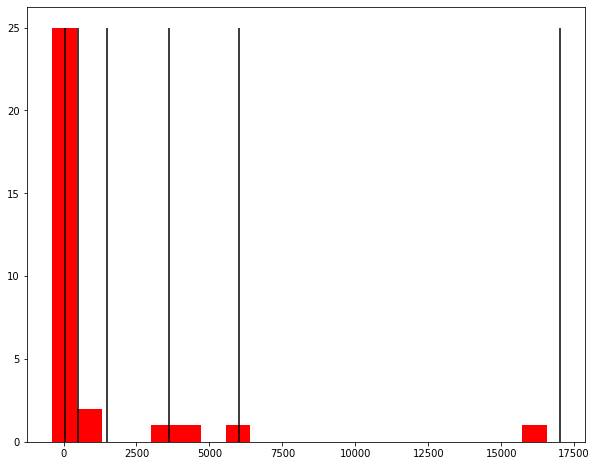

In [ ]:
# Plota as classes determinadas por quebras naturais
plt.style.use('seaborn-pastel')

%matplotlib inline
plt.figure(figsize = (10,8))
hist = plt.hist(data, bins=20, align='left', color='r')
for b in breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

## Mapa

In [ ]:
# Consultando os dados espaciais do curso escolhido no widget
cursor.execute("""CREATE OR REPLACE VIEW vagas_cursos_ocde AS SELECT iesup.cod_ies, sum(qta_vagas) as qta_vagas, iesup.geom, cod_ocde_area FROM cursos_emec, iesup 
WHERE cursos_emec.cod_ies = iesup.cod_ies AND nm_ocde_area_geral = 'Educaçao' AND cod_ocde_area = '%s'
GROUP BY iesup.cod_ies, iesup.geom, cursos_emec.cod_ocde_area; """ %(nome_area))
conn.commit()
# cursor.close()
# conn.close()

In [ ]:
classes = breaks

m = folium.Map(location = [-24.647,-51.578],
               height = '90%',
               zoom_start = 8,
               tiles = 'OpenStreetMap')

# Municipios
folium.WmsTileLayer(
    url = 'http://200.17.225.171:8081/geoserver/mapfor/wms', 
    layers = 'mapfor:pr_mun_num_prof',  
    fmt='image/png', 
    transparent=True, 
    version='1.1.1', 
    name = 'Municipio PR', 
    overlay=True, 
    control=True, 
    show=True).add_to(m)

# Regionais de Educação
folium.WmsTileLayer(
    url = 'http://200.17.225.171:8081/geoserver/mapfor/wms', 
    layers = 'mapfor:NRE_pr',  
    fmt='image/png', 
    transparent=True, 
    version='1.1.1', 
    name = 'NRE', 
    overlay=True, 
    control=True, 
    show=True).add_to(m)

# Pontos vagas
folium.WmsTileLayer(
  url = 'http://200.17.225.171:8081/geoserver/mapfor/wms?request=GetMap&env=inicial1:%s;final1:%s;inicial1:%s;final2:%s;inicial3:%s;final3:%s;inicial4:%s;final4:%s;inicial5:%s;final5:%s' %(classes[0], classes[1], classes[1], classes[2], classes[2], classes[3], classes[3], classes[4], classes[4], classes[5]), 
  layers = 'mapfor:vagas_cursos_ocde',  
  fmt='image/png', 
  transparent=True, 
  version='1.1.1', 
  name = 'Vagas Licenciatura', 
  overlay=True, 
  control=True, 
  show=True).add_to(m)

folium.LayerControl().add_to(m)
m

# Mapa das escolas de ensino básico e seus índices

In [ ]:
import json
# Consulta escolas geometria ponto
cursor.execute("""CREATE OR REPLACE VIEW esc_est_wgs AS SELECT esc_est.*, ST_Transform(geom,4326) As geom_wgs FROM esc_est; """)
cursor.execute("""SELECT row_to_json(fc) FROM ( SELECT 'FeatureCollection' As type, array_to_json(array_agg(f)) As features
FROM (SELECT 'Feature' As type, ST_AsGeoJSON(lg.geom_wgs)::json As geometry, row_to_json((SELECT l FROM (SELECT cod_esc) As l)) As properties
FROM esc_est_wgs As lg   ) As f )  As fc;""")
esc_est_gjson = json.dumps(cursor.fetchall())
conn.commit()

cursor.execute("""CREATE OR REPLACE VIEW esc_part_wgs AS SELECT esc_part.*, ST_Transform(geom,4326) As geom_wgs FROM esc_part; """)
cursor.execute("""SELECT row_to_json(fc) FROM ( SELECT 'FeatureCollection' As type, array_to_json(array_agg(f)) As features
FROM (SELECT 'Feature' As type, ST_AsGeoJSON(lg.geom_wgs)::json As geometry, row_to_json((SELECT l FROM (SELECT cod_esc) As l)) As properties
FROM esc_est_wgs As lg   ) As f )  As fc;""")
esc_part_gjson = json.dumps(cursor.fetchall())
conn.commit()

# print (esc_geojson[2:len(esc_geojson)-2])

In [ ]:
from folium.plugins import MarkerCluster

m = folium.Map(location = [-24.647,-51.578],
               height = '90%',
               zoom_start = 8,
               tiles = 'OpenStreetMap')

# Municipios
folium.WmsTileLayer(
    url = 'http://200.17.225.171:8081/geoserver/mapfor/wms', 
    layers = 'mapfor:pr_mun',  
    fmt='image/png', 
    transparent=True, 
    version='1.1.1', 
    name = 'Municipio PR', 
    overlay=True, 
    control=True, 
    show=True).add_to(m)

# Mancha urbana
folium.WmsTileLayer(
    url = 'http://200.17.225.171:8081/geoserver/mapfor/wms', 
    layers = 'mapfor:urbano',  
    fmt='image/png', 
    transparent=True, 
    version='1.1.1', 
    name = 'Urbano', 
    overlay=True, 
    control=True, 
    show=True).add_to(m)

# Regionais
folium.WmsTileLayer(
    url = 'http://200.17.225.171:8081/geoserver/mapfor/wms', 
    layers = 'mapfor:NRE_pr',  
    fmt='image/png', 
    transparent=True, 
    version='1.1.1', 
    name = 'NRE', 
    overlay=True, 
    control=True, 
    show=True).add_to(m)

# Escolas
ft_grp = folium.FeatureGroup(name = 'Escolas')

marker_cluster = MarkerCluster(
    name = 'Escolas',
).add_to(ft_grp)

esc_1 = folium.GeoJson(
    esc_est_gjson[2:len(esc_est_gjson)-2],
    overlay=True
    ).add_to(marker_cluster)

esc_2 = folium.GeoJson(
    esc_part_gjson[2:len(esc_part_gjson)-2],
    overlay=True
    ).add_to(marker_cluster)

m.add_child(ft_grp)
folium.LayerControl().add_to(m)

m